## POOL UMA_FEI

### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
EXPERIMENT_ID = 79

X_NAME = 'UMA'
Y_NAME = 'FEI'

WINDOW_SIZE = 24 * 60 * 60

In [4]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [5]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [6]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [7]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [8]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,4,FEI,UMA,29763.930711,0.0,2014.242356,119.055723,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,7.0,2021-11-23 23:19:32,2021-11-23 23:19:21,0x9545c5bc50defba38e1cb3d15efdbeb5ab81912e06fa...,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,4,549472.610295,8.008752e+06,4.400590e+12,0,0,False,547458.367939,8.038397e+06,4.400688e+12,0,0,False,14.683120,0.007394
1,5,FEI,UMA,14991.490675,0.0,1008.928861,59.965963,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,13.0,2021-11-23 23:21:02,2021-11-23 23:20:54,0x4756c2afc0a426a358fc48596b1105458296d08bae40...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,5,547458.367939,8.038397e+06,4.400688e+12,0,0,False,546449.439078,8.053329e+06,4.400737e+12,1321,6,False,14.737555,0.003707
2,6,FEI,UMA,14923.378191,0.0,1000.647021,59.693513,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,403.0,2021-11-24 00:58:32,2021-11-24 00:58:28,0xec06f0c0627a48c286675dab3b52b12162e276fdc1c7...,0x8698d9d5ea99809c00426484a80be2add4e54581,0x157dfa656fdf0d18e1ba94075a53600d81cb3a97,6,546449.439078,8.053329e+06,4.400737e+12,1321,6,False,545448.792057,8.068192e+06,4.400786e+12,87536,403,False,14.791842,0.003684
3,7,UMA,FEI,997.650000,0.0,14583.103737,58.332415,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,841.0,2021-11-24 02:48:02,2021-11-24 02:47:58,0xf5bb16d17347ac05b7cb88082d2ccba93a35193b4372...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,7,545448.792057,8.068192e+06,4.400786e+12,87536,403,False,546446.442057,8.053551e+06,4.400834e+12,184718,847,False,14.738042,-0.003637
4,8,UMA,FEI,1448.948091,0.0,21085.760194,84.343041,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1019.0,2021-11-24 03:32:32,2021-11-24 03:32:20,0xfee2383f6e7cc0d6cb0f53229dc636cb0dc756112e31...,0x8698d9d5ea99809c00426484a80be2add4e54581,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,8,546446.442057,8.053551e+06,4.400834e+12,184718,847,False,547895.390148,8.032381e+06,4.400904e+12,224069,1028,False,14.660428,-0.005266


In [9]:
swaps0_df.status.value_counts()

SUCCESS    26
Name: status, dtype: int64

In [10]:
swaps1_df.status.value_counts()

SUCCESS    26
Name: status, dtype: int64

In [11]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.0


In [12]:
swaps1_df.mitigator_check_status.value_counts()

CANT_CONSULT_ORACLE    22
CHECKED                 4
Name: mitigator_check_status, dtype: int64

In [13]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.8461538461538461


In [14]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
Series([], Name: status, dtype: int64)

Burns status with volatility mitigation mechanism
Series([], Name: status, dtype: int64)


**0** have been **blocked by the volatility mitigation mechanism**. In about **77%** of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle

In [32]:
2

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,4,FEI,UMA,29763.930711,0.0,2014.242356,119.055723,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,7.0,2021-11-23 23:19:32,2021-11-23 23:19:21,0x9545c5bc50defba38e1cb3d15efdbeb5ab81912e06fa...,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,4,549472.610295,8.008752e+06,4.400590e+12,0,0,True,547458.367939,8.038397e+06,4.400688e+12,0,0,True,14.683120,0.007394
1,5,FEI,UMA,14991.490675,0.0,1008.928861,59.965963,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,13.0,2021-11-23 23:21:02,2021-11-23 23:20:54,0x4756c2afc0a426a358fc48596b1105458296d08bae40...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,5,547458.367939,8.038397e+06,4.400688e+12,0,0,True,546449.439078,8.053329e+06,4.400737e+12,1321,6,True,14.737555,0.003707
2,6,FEI,UMA,14923.378191,0.0,1000.647021,59.693513,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,403.0,2021-11-24 00:58:32,2021-11-24 00:58:28,0xec06f0c0627a48c286675dab3b52b12162e276fdc1c7...,0x8698d9d5ea99809c00426484a80be2add4e54581,0x157dfa656fdf0d18e1ba94075a53600d81cb3a97,6,546449.439078,8.053329e+06,4.400737e+12,1321,6,True,545448.792057,8.068192e+06,4.400786e+12,87536,403,True,14.791842,0.003684
3,7,UMA,FEI,997.650000,0.0,14583.103737,58.332415,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,841.0,2021-11-24 02:48:02,2021-11-24 02:47:58,0xf5bb16d17347ac05b7cb88082d2ccba93a35193b4372...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,7,545448.792057,8.068192e+06,4.400786e+12,87536,403,True,546446.442057,8.053551e+06,4.400834e+12,184718,847,True,14.738042,-0.003637
4,8,UMA,FEI,1448.948091,0.0,21085.760194,84.343041,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1019.0,2021-11-24 03:32:32,2021-11-24 03:32:20,0xfee2383f6e7cc0d6cb0f53229dc636cb0dc756112e31...,0x8698d9d5ea99809c00426484a80be2add4e54581,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,8,546446.442057,8.053551e+06,4.400834e+12,184718,847,True,547895.390148,8.032381e+06,4.400904e+12,224069,1028,True,14.660428,-0.005266
5,9,UMA,FEI,2946.875181,0.0,42543.890095,170.175560,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1023.0,2021-11-24 03:33:32,2021-11-24 03:33:29,0x52ee629a9565a7b0ea163f3903abfc5d59c45542e463...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,9,547895.390148,8.032381e+06,4.400904e+12,224069,1028,True,550842.265329,7.989667e+06,4.401046e+12,224948,1032,True,14.504455,-0.010639
6,10,UMA,FEI,1775.024141,0.0,25407.246362,101.628985,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1832.0,2021-11-24 06:55:47,2021-11-24 06:55:44,0xb3e6b5c9f401d00c1eafe1f0f44407c88e3ba947b5a1...,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,10,550842.265329,7.989667e+06,4.401046e+12,224948,1032,True,552617.289470,7.964158e+06,4.401131e+12,400960,1869,True,14.411706,-0.006395
7,11,UMA,FEI,1957.490510,0.0,27831.071547,111.324286,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,2581.0,2021-11-24 10:03:02,2021-11-24 10:02:48,0x74bf221fb2d4b73efcec4dc575eddae5b6f287dd13e6...,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,11,552617.289470,7.964158e+06,4.401131e+12,400960,1869,True,554574.779980,7.936215e+06,4.401225e+12,562875,2648,True,14.310451,-0.007026
8,12,UMA,FEI,2125.189821,0.0,29994.508361,119.978033,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,2609.0,2021-11-24 10:10:02,2021-11-24 10:09:55,0xc554eb631f2770a867f8e1234e4537c44c3a1df948cd...,0x27239549dd40e1d60f5b80b0c4196923745b

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

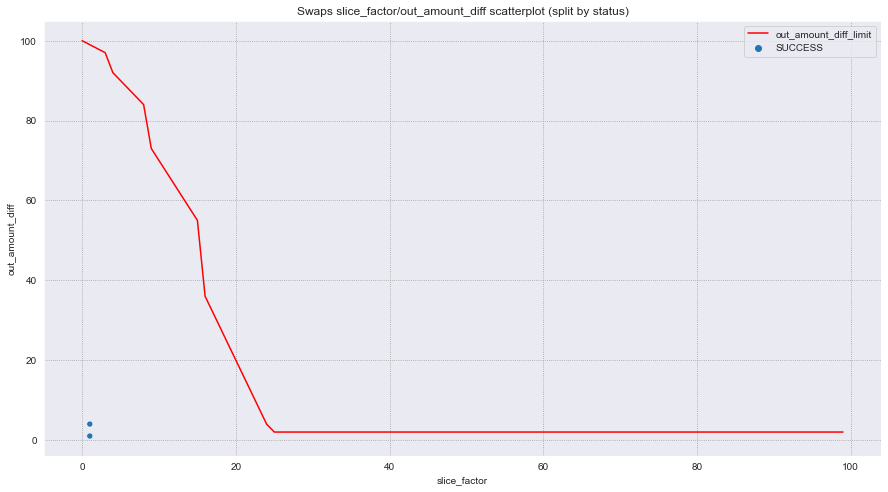

In [15]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**It can be observed that for all swaps checked by the volatility mitigation mechanism the slice_factor is pretty small, which is caused by the high pool reserves. The limit until which a transaction would be blocked is pretty big**

Text(0, 0.5, 'Count')

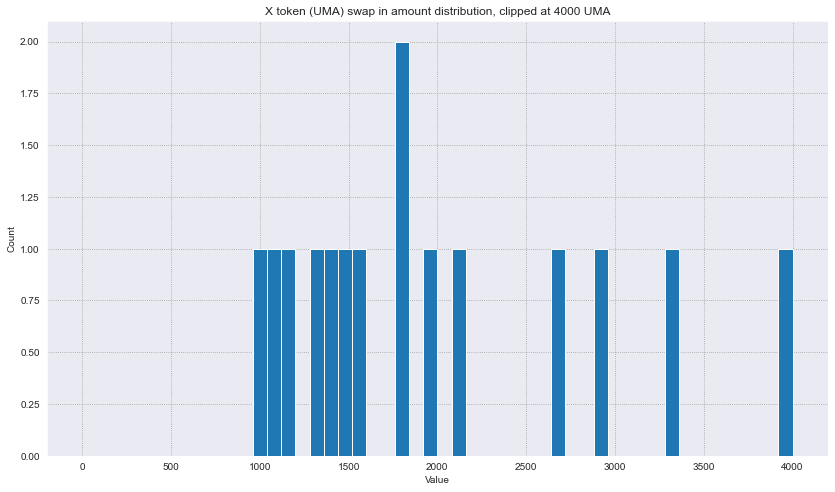

In [16]:
UPPER_LIMIT = 4000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

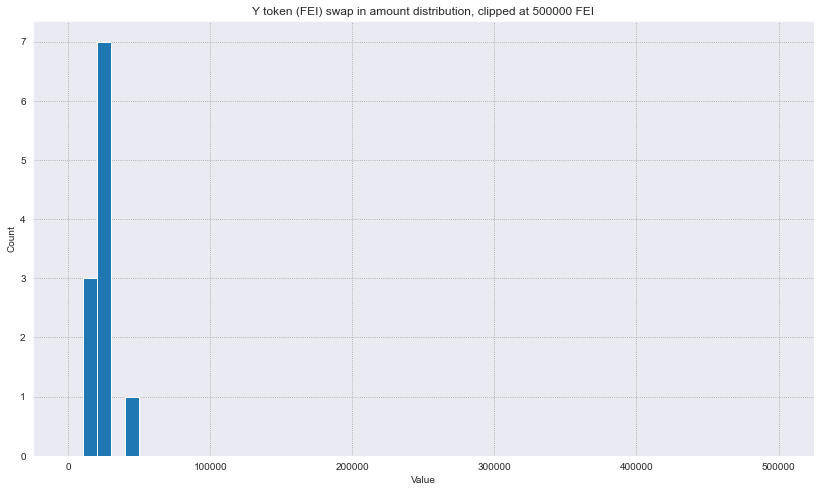

In [17]:
UPPER_LIMIT = 500000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

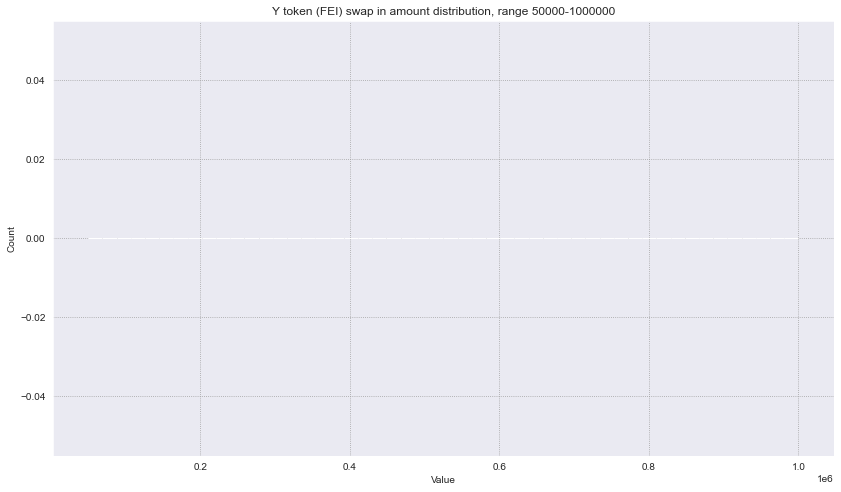

In [18]:
LOWER_LIMIT = 50000
UPPER_LIMIT = 1000000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

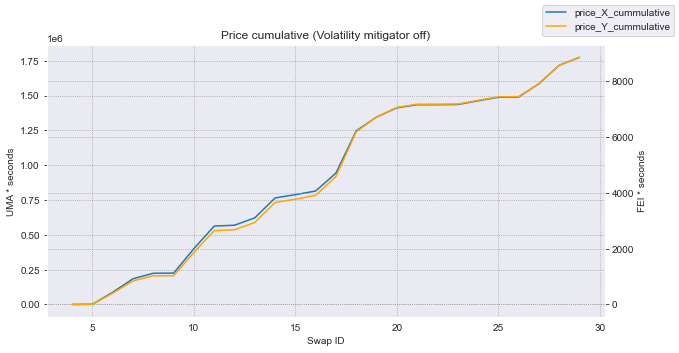

In [19]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

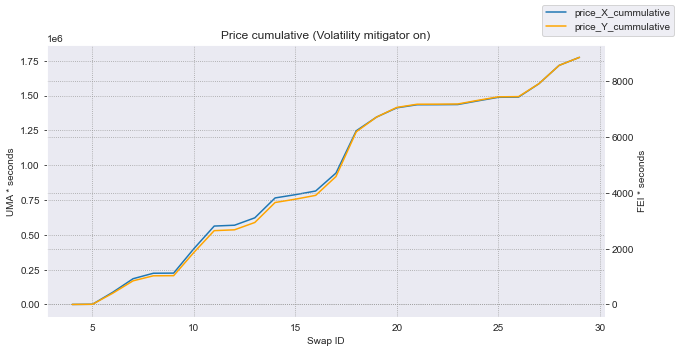

In [20]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

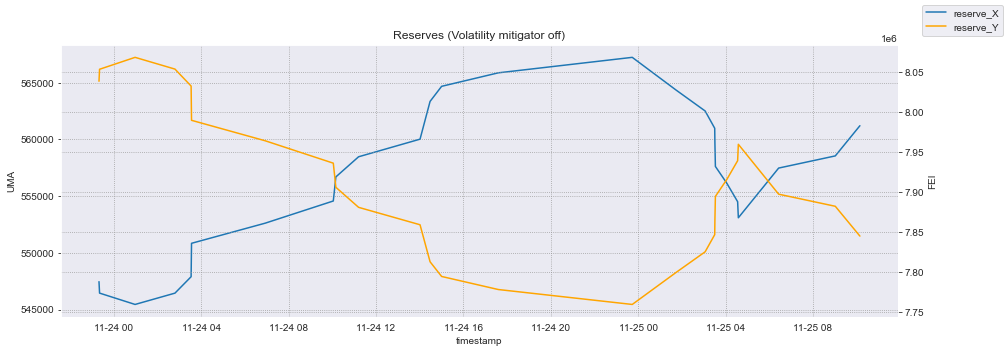

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

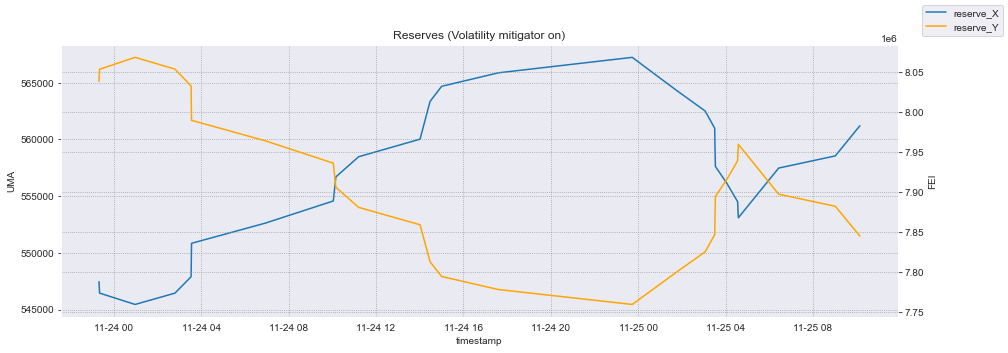

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**As no transactions have been blocked, the variation of reserves over time with and without the volatility mitigation mechanism is the same**

In [28]:
mints1_df['Date'] = pd.to_datetime(mints1_df.timestamp, unit='s')

In [31]:
mints1_df

,id,X_amount,Y_amount,timestamp,status,block_number,block_timestamp,transaction_timestamp,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,Date
0,0,137218.102084,2.000001e+06,1637709467,SUCCESS,0,1637709467,1637709467,0,0.000000,0.000000e+00,0.000000e+00,0,0,True,137218.102084,2.000001e+06,2.744363e+11,0,0,True,2021-11-23 23:17:47
1,1,137218.033475,2.000000e+06,1637709467,SUCCESS,0,1637709467,1637709467,1,137218.102084,2.000001e+06,2.744363e+11,0,0,True,274436.135559,4.000001e+06,1.097745e+12,0,0,True,2021-11-23 23:17:47
2,2,137536.474736,2.004641e+06,1637709467,SUCCESS,0,1637709467,1637709467,2,274436.135559,4.000001e+06,1.097745e+12,0,0,True,411972.610295,6.004642e+06,2.473748e+12,0,0,True,2021-11-23 23:17:47
3,3,137500.000000,2.004110e+06,1637709467,SUCCESS,0,1637709467,1637709467,3,411972.610295,6.004642e+06,2.473748e+12,0,0,True,549472.610295,8.008752e+06,4.400590e+12,0,0,True,2021-11-23 23:17:47


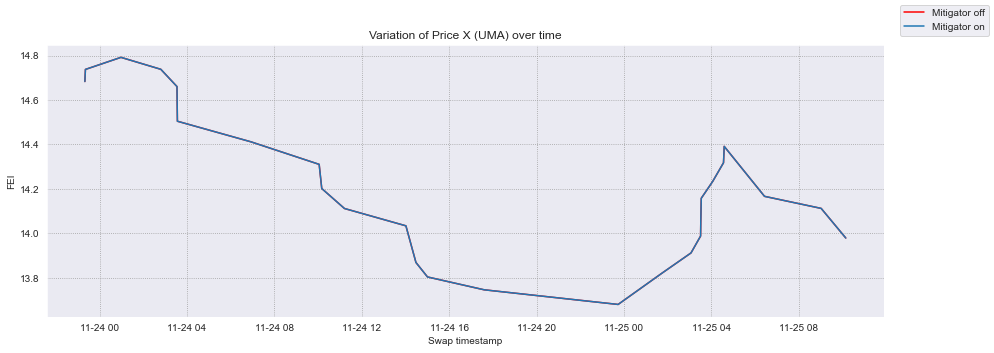

In [55]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**The variation of price is also the same**

## Count number of 1 hour periods with no swaps

Below, the distribution of the number of swaps per hour, for 3 stages of the same duration of the pool is computed 

- 1st stage - initial period 
- 2nd stage - middle period
- 3nd stage - last period

In [56]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled = sim1_indexed_df.resample('1h').size()
resampled

transaction_timestamp
2021-11-23 23:00:00    2
2021-11-24 00:00:00    1
2021-11-24 01:00:00    0
2021-11-24 02:00:00    1
2021-11-24 03:00:00    2
2021-11-24 04:00:00    0
2021-11-24 05:00:00    0
2021-11-24 06:00:00    1
2021-11-24 07:00:00    0
2021-11-24 08:00:00    0
2021-11-24 09:00:00    0
2021-11-24 10:00:00    2
2021-11-24 11:00:00    1
2021-11-24 12:00:00    0
2021-11-24 13:00:00    0
2021-11-24 14:00:00    2
2021-11-24 15:00:00    1
2021-11-24 16:00:00    0
2021-11-24 17:00:00    1
2021-11-24 18:00:00    0
2021-11-24 19:00:00    0
2021-11-24 20:00:00    0
2021-11-24 21:00:00    0
2021-11-24 22:00:00    0
2021-11-24 23:00:00    1
2021-11-25 00:00:00    0
2021-11-25 01:00:00    1
2021-11-25 02:00:00    0
2021-11-25 03:00:00    4
2021-11-25 04:00:00    3
2021-11-25 05:00:00    0
2021-11-25 06:00:00    1
2021-11-25 07:00:00    0
2021-11-25 08:00:00    0
2021-11-25 09:00:00    1
2021-11-25 10:00:00    1
Freq: H, dtype: int64

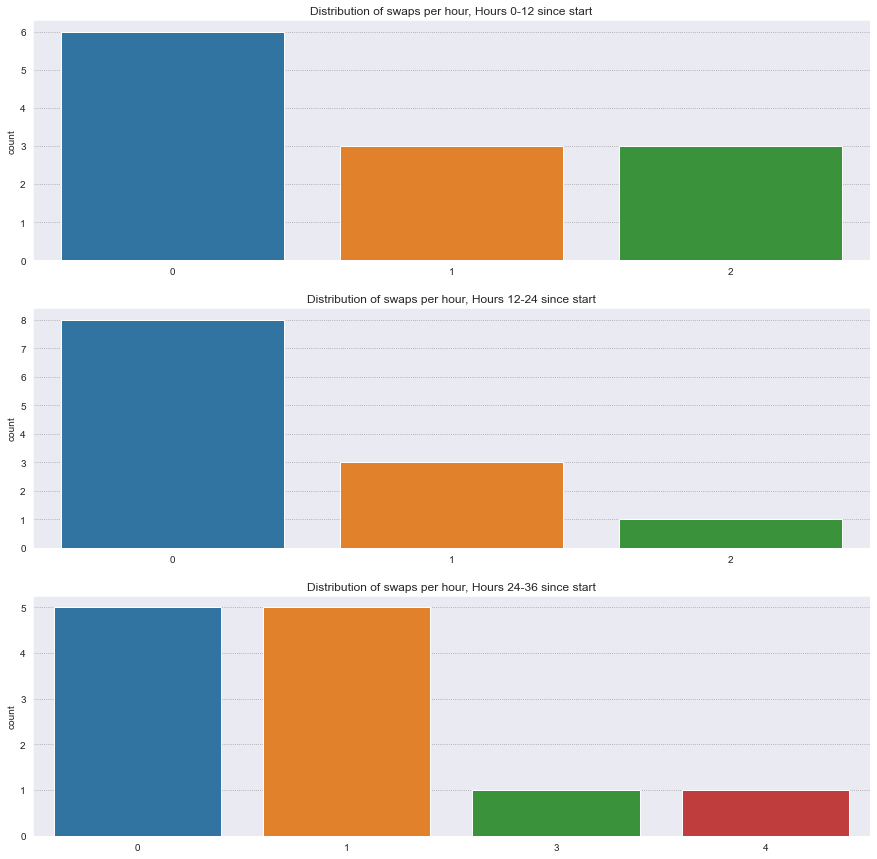

In [25]:
N_STAGES = 3

fig, ax = plt.subplots(N_STAGES, 1, figsize=(15, N_STAGES*5))
ax = ax.ravel()

n = len(resampled)

for i in range(0, N_STAGES):
    start_idx = i * (n // N_STAGES)
    end_idx = (i + 1) * (n // N_STAGES)
   # time_elapsed = (resampled.index[end_idx] - resampled.index[start_idx])
    
    sns.countplot(x=resampled.iloc[start_idx:end_idx], ax=ax[i])
    ax[i].set_title(f"Distribution of swaps per hour, Hours {start_idx}-{end_idx} since start")
   # ax.set_title('Swaps per hour distribution')

**The count for x = 0 (no swaps per hour), shows how many missing periods for TWAP value exist. It can be seen that this number increases over time**

## Count number of 24 hour periods with no swaps

In [26]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled48 = sim1_indexed_df.resample('48h').size()
resampled48.head()

transaction_timestamp
2021-11-23    15
2021-11-25    11
Freq: 48H, dtype: int64

In [27]:
resampled48[resampled48 == 0].shape

(0,)

ValueError: min() arg is an empty sequence

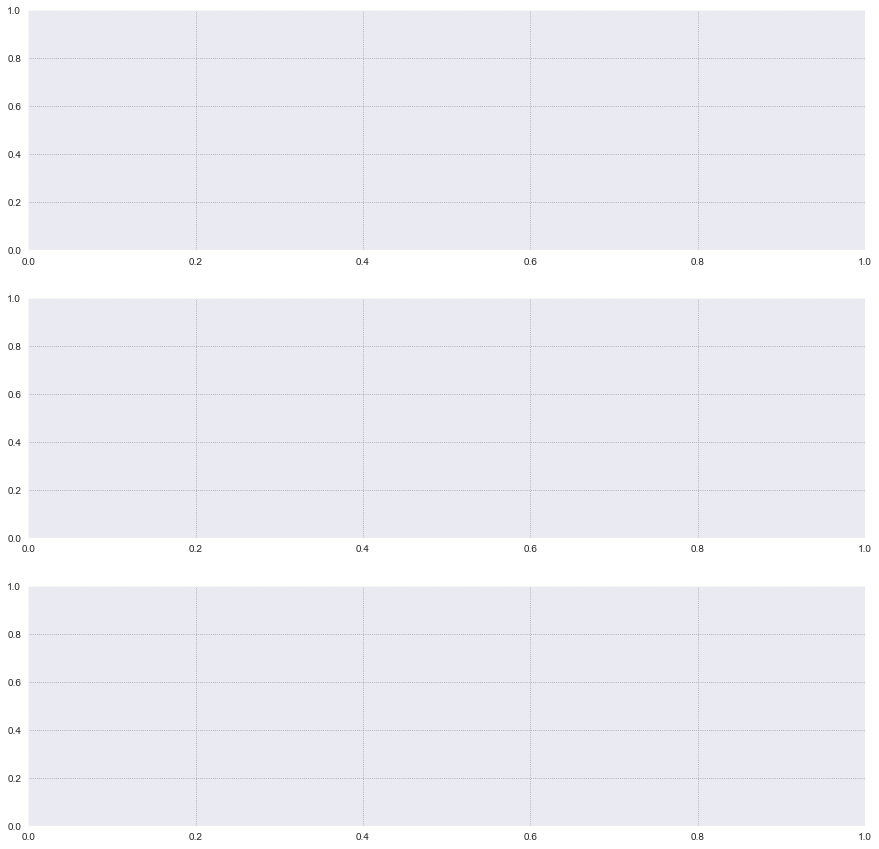

In [32]:
N_STAGES = 3

fig, ax = plt.subplots(N_STAGES, 1, figsize=(15, N_STAGES*5))
ax = ax.ravel()

n = len(resampled48)

for i in range(0, N_STAGES):
    start_idx = i * (n // N_STAGES)
    end_idx = (i + 1) * (n // N_STAGES)
    
    sns.countplot(x=resampled48.iloc[start_idx:end_idx], ax=ax[i])
    ax[i].set_title(f"Distribution of swaps per 48 hours, Days {start_idx}-{end_idx} since start")
   # ax.set_title('Swaps per hour distribution')

**It can be seen that in the second stage the minimum number of swaps in 48 hours is 2, and in the last case, there are only 3 48-hour windows with no swaps happening**

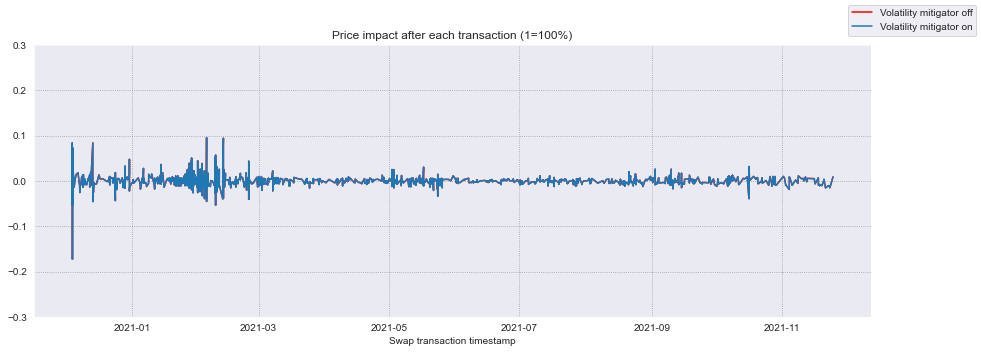

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

**The price impact after each transaction doesn't exceed 0.25**

In [37]:
swaps1_df[swaps1_df.price_diff > 0.2]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff


**The transaction which cause the highest price impact wasn't checked by the volatility mitigation mechanism due to no priceCummulative observations available. It can be observed, that after this transaction, in the next 10 minutes followed 10 other swaps in another direction, which returned the price of the security token to the initial value, stabilizing the price**

In [38]:
swaps1_df.iloc[725:740]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
725,916,UST,mBABA,18000.000000,0.0,75.271306,72.000000,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,552976,2021-03-09 16:44:45,2021-03-09 16:44:32,0x04603a444f242dc8b8bbb5c444907ff30cf9f5207eaf...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x77645329c920870c84167fdf5c0db152733ad2ee,916,35543.418452,8.396857e+06,2.984530e+11,2141780999,32248,True,35468.147147,8.414785e+06,2.984568e+11,2143148841,32273,True,237.249070,0.004262
726,917,UST,mBABA,20000.000000,0.0,83.260685,80.000000,CHECKED,85.854274,3.0,1.0,1.0,SUCCESS,553290,2021-03-09 18:03:15,2021-03-09 18:03:04,0xcdc4148123c09c96e06dc51ae1cfa79f799e3e692f3a...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x77645329c920870c84167fdf5c0db152733ad2ee,917,35468.147147,8.414785e+06,2.984568e+11,2143148841,32273,True,35384.886462,8.434705e+06,2.984611e+11,2144266284,32293,True,238.370269,0.004726
727,918,UST,mBABA,15000.000000,0.0,62.188549,60.000000,CHECKED,64.332749,3.0,1.0,1.0,SUCCESS,553510,2021-03-09 18:58:15,2021-03-09 18:58:02,0x227a84d45c0574d7c06ad05bac3dc8351c84e966aac5...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x2c691e3c7c05ebd156e40684ee299f2de62a9fd7,918,35384.886462,8.434705e+06,2.984611e+11,2144266284,32293,True,35322.697913,8.449645e+06,2.984643e+11,2145052906,32306,True,239.212897,0.003535
728,919,UST,mBABA,5000.000000,0.0,20.680749,20.000000,CHECKED,21.444250,3.0,1.0,1.0,SUCCESS,553510,2021-03-09 18:58:15,2021-03-09 18:58:02,0x8056b377a9965d64e0e79972a4b0d592188e160d2ba8...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xfc41cc8340320d6ebdb3b64149c1fbc8f0295361,919,35322.697913,8.449645e+06,2.984643e+11,2145052906,32306,True,35302.017164,8.454625e+06,2.984653e+11,2145052906,32306,True,239.494102,0.001176
729,920,UST,mBABA,15000.000000,0.0,61.896984,60.000000,CHECKED,64.331832,3.0,1.0,1.0,SUCCESS,553513,2021-03-09 18:59:00,2021-03-09 18:58:53,0x1c73cdb8f08266e46ee9ab95bab2edf4fb15ac257041...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x58217de7140d3a939d1a43a19c92c3d97c1d7cbc,920,35302.017164,8.454625e+06,2.984653e+11,2145052906,32306,True,35240.120180,8.469565e+06,2.984685e+11,2145063683,32307,True,240.338707,0.003527
730,921,UST,mBABA,25000.000000,0.0,102.679614,100.000000,CHECKED,107.219719,4.0,1.0,1.0,SUCCESS,553513,2021-03-09 18:59:00,2021-03-09 18:58:53,0x96c0b39144d547dc4228976deaf7f46d680571c990ed...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x77645329c920870c84167fdf5c0db152733ad2ee,921,35240.120180,8.469565e+06,2.984685e+11,2145063683,32307,True,35137.440566,8.494465e+06,2.984738e+11,2145063683,32307,True,241.749677,0.005871
731,922,mBABA,UST,103.711884,0.0,24749.271741,98.997087,CHECKED,24184.296272,2.0,1.0,1.0,SUCCESS,553516,2021-03-09 18:59:45,2021-03-09 18:59:32,0x40b5fa5506239bad9ea431cd49e214482e1bf5104f5d...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x77645329c920870c84167fdf5c0db152733ad2ee,922,35137.440566,8.494465e+06,2.984738e+11,2145063683,32307,True,35241.152450,8.469617e+06,2.984791e+11,2145074562,32307,True,240.333135,-0.005860
732,923,UST,mBABA,48.239390,0.0,0.198711,0.192958,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,555154,2021-03-10 01:49:15,2021-03-10 01:49:03,0xd38977c6f4c2c1156b1e884f00772c22a63cf42df155...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x5dfc5379d98b21e40167c7a158c39a7f68694503,923,35241.152450,8.469617e+06,2.984791e+11,2145074562,32307,True,35240.953739,8.469665e+06,2.984791e+11,2150979547,32409,True,240.335853,0.000011
733,925,UST,mBABA,31037.000000,0.0,127.386578,124.148000,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,555347,202

**! See how the changes influence the results in notebooks with suffix _mod1 and _mod2**

In [59]:
mints1_df.timestamp = pd.to_datetime(mints1_df.timestamp, unit='s')

In [60]:
burns1_df.timestamp = pd.to_datetime(burns1_df.timestamp, unit='s')

In [61]:
mints1_indexed_df = mints1_df.copy()
mints1_indexed_df.index = mints1_indexed_df.timestamp
resampled = mints1_indexed_df.resample('24h').size()
resampled.head()

timestamp
2021-11-23    4
Freq: 24H, dtype: int64

Text(0, 0.5, 'Count')

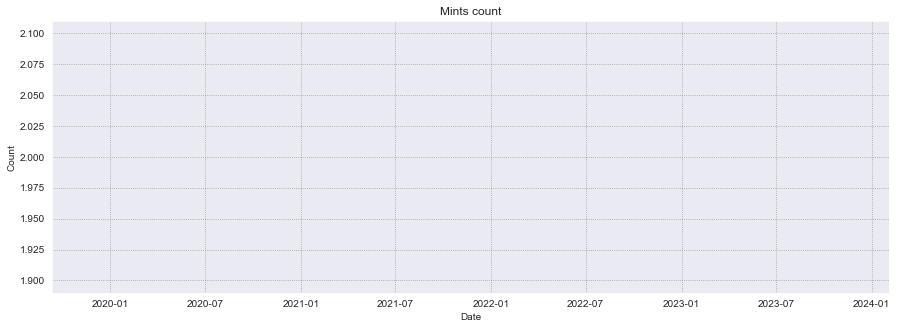

In [62]:
mints1_indexed_df = mints1_df.copy()
mints1_indexed_df.index = mints1_df.timestamp
mints1_indexed_df.loc[mints1_df.timestamp.min()] = np.nan
mints1_indexed_df.loc[mints1_df.timestamp.max()] = np.nan
resampled = mints1_indexed_df.resample('24h').size()
resampled[0] -= 1
resampled[-1] -= 1
resampled.head()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled.index, y=resampled.values, linestyle='solid', color='red', marker=None,)

ax.set_title("Mints count")
ax.set_xlabel('Date')
ax.set_ylabel('Count')
#ax.set_xlim(swaps1_df.transaction_timestamp.min(), swaps1_df.transaction_timestamp.max())

Text(0, 0.5, 'Count')

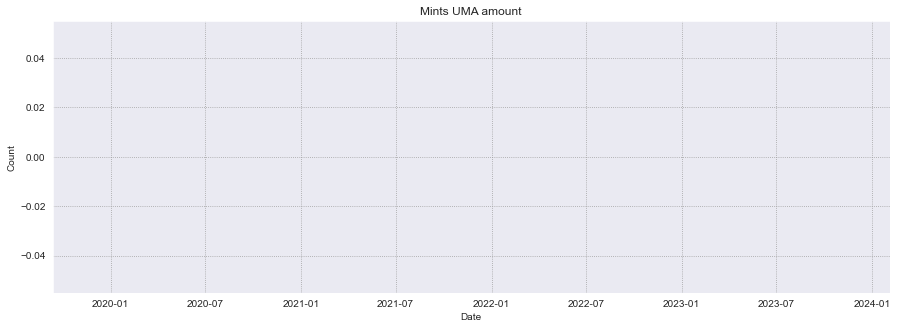

In [63]:
mints1_indexed_df = mints1_df.copy()
mints1_indexed_df.index = mints1_df.timestamp
mints1_indexed_df.loc[mints1_df.timestamp.min()] = np.nan
mints1_indexed_df.loc[mints1_df.timestamp.max()] = np.nan
resampled = mints1_indexed_df.resample('24h').sum()
#resampled[0] -= 1
#resampled[-1] -= 1
resampled.head()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled.index, y=resampled.X_amount, linestyle='solid', color='red', marker=None,)

ax.set_title(f"Mints {X_NAME} amount")
ax.set_xlabel('Date')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

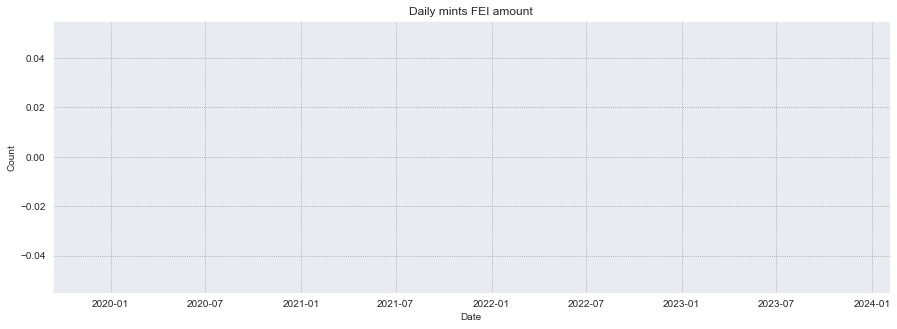

In [64]:
mints1_indexed_df = mints1_df.copy()
mints1_indexed_df.index = mints1_df.timestamp
mints1_indexed_df.loc[mints1_df.timestamp.min()] = np.nan
mints1_indexed_df.loc[mints1_df.timestamp.max()] = np.nan
resampled = mints1_indexed_df.resample('24h').sum()
#resampled[0] -= 1
#resampled[-1] -= 1
resampled.head()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled.index, y=resampled.Y_amount, linestyle='solid', color='red', marker=None,)

ax.set_title(f"Daily mints {Y_NAME} amount")
ax.set_xlabel('Date')
ax.set_ylabel('Count')

In [65]:
burns_indexed_df = burns1_df.copy()
burns_indexed_df.index = burns_indexed_df.timestamp
burns_indexed_df.loc[burns_indexed_df.timestamp.min()] = np.nan
burns_indexed_df.loc[burns_indexed_df.timestamp.max()] = np.nan
resampled = burns_indexed_df.resample('24h').sum()
#resampled[0] -= 1
#resampled[-1] -= 1
resampled.head()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled.index, y=resampled.X_amount, linestyle='solid', color='red', marker=None,)

ax.set_title(f"Daily burns {X_NAME} amount")
ax.set_xlabel('Date')
ax.set_ylabel('Count')

AttributeError: 'NaTType' object has no attribute 'tz'

In [66]:
burns_indexed_df = burns1_df.copy()
burns_indexed_df.index = burns_indexed_df.timestamp
burns_indexed_df.loc[burns_indexed_df.timestamp.min()] = np.nan
burns_indexed_df.loc[burns_indexed_df.timestamp.max()] = np.nan
resampled = burns_indexed_df.resample('24h').sum()
#resampled[0] -= 1
#resampled[-1] -= 1
resampled.head()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled.index, y=resampled.Y_amount, linestyle='solid', color='red', marker=None,)

ax.set_title(f"Daily burns {Y_NAME} amount")
ax.set_xlabel('Date')
ax.set_ylabel('Count')

AttributeError: 'NaTType' object has no attribute 'tz'

Text(0, 0.5, 'Count')

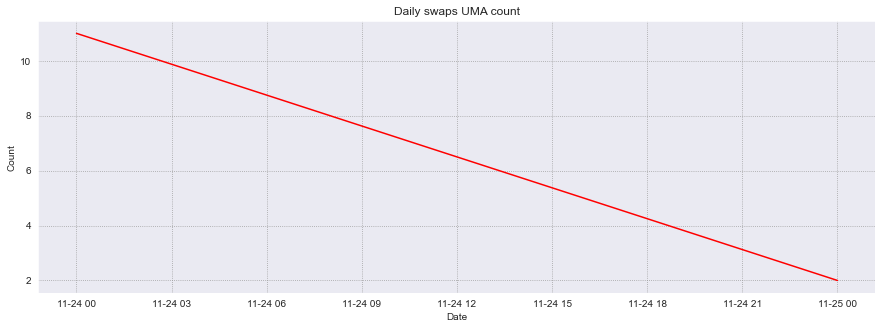

In [67]:
swaps_indexed_df = swaps1_df[swaps1_df.token_in == X_NAME].copy()
swaps_indexed_df.index = swaps_indexed_df.transaction_timestamp
swaps_indexed_df.loc[swaps_indexed_df.transaction_timestamp.min()] = np.nan
swaps_indexed_df.loc[swaps_indexed_df.transaction_timestamp.max()] = np.nan
resampled = swaps_indexed_df.resample('24h').size()
#resampled[0] -= 1
#resampled[-1] -= 1
resampled.head()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled.index, y=resampled.values, linestyle='solid', color='red', marker=None,)

ax.set_title(f"Daily swaps {X_NAME} count")
ax.set_xlabel('Date')
ax.set_ylabel('Count')

In [68]:
swaps1_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,4,FEI,UMA,29763.930711,0.0,2014.242356,119.055723,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,7.0,2021-11-23 23:19:32,2021-11-23 23:19:21,0x9545c5bc50defba38e1cb3d15efdbeb5ab81912e06fa...,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,4,549472.610295,8.008752e+06,4.400590e+12,0,0,True,547458.367939,8.038397e+06,4.400688e+12,0,0,True,14.683120,0.007394
1,5,FEI,UMA,14991.490675,0.0,1008.928861,59.965963,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,13.0,2021-11-23 23:21:02,2021-11-23 23:20:54,0x4756c2afc0a426a358fc48596b1105458296d08bae40...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,5,547458.367939,8.038397e+06,4.400688e+12,0,0,True,546449.439078,8.053329e+06,4.400737e+12,1321,6,True,14.737555,0.003707
2,6,FEI,UMA,14923.378191,0.0,1000.647021,59.693513,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,403.0,2021-11-24 00:58:32,2021-11-24 00:58:28,0xec06f0c0627a48c286675dab3b52b12162e276fdc1c7...,0x8698d9d5ea99809c00426484a80be2add4e54581,0x157dfa656fdf0d18e1ba94075a53600d81cb3a97,6,546449.439078,8.053329e+06,4.400737e+12,1321,6,True,545448.792057,8.068192e+06,4.400786e+12,87536,403,True,14.791842,0.003684
3,7,UMA,FEI,997.650000,0.0,14583.103737,58.332415,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,841.0,2021-11-24 02:48:02,2021-11-24 02:47:58,0xf5bb16d17347ac05b7cb88082d2ccba93a35193b4372...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,7,545448.792057,8.068192e+06,4.400786e+12,87536,403,True,546446.442057,8.053551e+06,4.400834e+12,184718,847,True,14.738042,-0.003637
4,8,UMA,FEI,1448.948091,0.0,21085.760194,84.343041,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1019.0,2021-11-24 03:32:32,2021-11-24 03:32:20,0xfee2383f6e7cc0d6cb0f53229dc636cb0dc756112e31...,0x8698d9d5ea99809c00426484a80be2add4e54581,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,8,546446.442057,8.053551e+06,4.400834e+12,184718,847,True,547895.390148,8.032381e+06,4.400904e+12,224069,1028,True,14.660428,-0.005266
5,9,UMA,FEI,2946.875181,0.0,42543.890095,170.175560,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1023.0,2021-11-24 03:33:32,2021-11-24 03:33:29,0x52ee629a9565a7b0ea163f3903abfc5d59c45542e463...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,9,547895.390148,8.032381e+06,4.400904e+12,224069,1028,True,550842.265329,7.989667e+06,4.401046e+12,224948,1032,True,14.504455,-0.010639
6,10,UMA,FEI,1775.024141,0.0,25407.246362,101.628985,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1832.0,2021-11-24 06:55:47,2021-11-24 06:55:44,0xb3e6b5c9f401d00c1eafe1f0f44407c88e3ba947b5a1...,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,10,550842.265329,7.989667e+06,4.401046e+12,224948,1032,True,552617.289470,7.964158e+06,4.401131e+12,400960,1869,True,14.411706,-0.006395
7,11,UMA,FEI,1957.490510,0.0,27831.071547,111.324286,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,2581.0,2021-11-24 10:03:02,2021-11-24 10:02:48,0x74bf221fb2d4b73efcec4dc575eddae5b6f287dd13e6...,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,11,552617.289470,7.964158e+06,4.401131e+12,400960,1869,True,554574.779980,7.936215e+06,4.401225e+12,562875,2648,True,14.310451,-0.007026
8,12,UMA,FEI,2125.189821,0.0,29994.508361,119.978033,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,2609.0,2021-11-24 10:10:02,2021-11-24 10:09:55,0xc554eb631f2770a867f8e1234e4537c44c3a1df948cd...,0x27239549dd40e1d60f5b80b0c4196923745b

In [73]:
mints1_df

,id,X_amount,Y_amount,timestamp,status,block_number,block_timestamp,transaction_timestamp,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on
0,0,137218.102084,2.000001e+06,2021-11-23 23:17:47,SUCCESS,0,1637709467,1637709467,0,0.000000,0.000000e+00,0.000000e+00,0,0,True,137218.102084,2.000001e+06,2.744363e+11,0,0,True
1,1,137218.033475,2.000000e+06,2021-11-23 23:17:47,SUCCESS,0,1637709467,1637709467,1,137218.102084,2.000001e+06,2.744363e+11,0,0,True,274436.135559,4.000001e+06,1.097745e+12,0,0,True
2,2,137536.474736,2.004641e+06,2021-11-23 23:17:47,SUCCESS,0,1637709467,1637709467,2,274436.135559,4.000001e+06,1.097745e+12,0,0,True,411972.610295,6.004642e+06,2.473748e+12,0,0,True
3,3,137500.000000,2.004110e+06,2021-11-23 23:17:47,SUCCESS,0,1637709467,1637709467,3,411972.610295,6.004642e+06,2.473748e+12,0,0,True,549472.610295,8.008752e+06,4.400590e+12,0,0,True


In [74]:
burns1_df

,id,X_amount,Y_amount,timestamp,status,block_number,block_timestamp,transaction_timestamp,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,transaction_id,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on


In [71]:
swaps1_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,4,FEI,UMA,29763.930711,0.0,2014.242356,119.055723,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,7.0,2021-11-23 23:19:32,2021-11-23 23:19:21,0x9545c5bc50defba38e1cb3d15efdbeb5ab81912e06fa...,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,4,549472.610295,8.008752e+06,4.400590e+12,0,0,True,547458.367939,8.038397e+06,4.400688e+12,0,0,True,14.683120,0.007394
1,5,FEI,UMA,14991.490675,0.0,1008.928861,59.965963,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,13.0,2021-11-23 23:21:02,2021-11-23 23:20:54,0x4756c2afc0a426a358fc48596b1105458296d08bae40...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,5,547458.367939,8.038397e+06,4.400688e+12,0,0,True,546449.439078,8.053329e+06,4.400737e+12,1321,6,True,14.737555,0.003707
2,6,FEI,UMA,14923.378191,0.0,1000.647021,59.693513,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,403.0,2021-11-24 00:58:32,2021-11-24 00:58:28,0xec06f0c0627a48c286675dab3b52b12162e276fdc1c7...,0x8698d9d5ea99809c00426484a80be2add4e54581,0x157dfa656fdf0d18e1ba94075a53600d81cb3a97,6,546449.439078,8.053329e+06,4.400737e+12,1321,6,True,545448.792057,8.068192e+06,4.400786e+12,87536,403,True,14.791842,0.003684
3,7,UMA,FEI,997.650000,0.0,14583.103737,58.332415,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,841.0,2021-11-24 02:48:02,2021-11-24 02:47:58,0xf5bb16d17347ac05b7cb88082d2ccba93a35193b4372...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,7,545448.792057,8.068192e+06,4.400786e+12,87536,403,True,546446.442057,8.053551e+06,4.400834e+12,184718,847,True,14.738042,-0.003637
4,8,UMA,FEI,1448.948091,0.0,21085.760194,84.343041,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1019.0,2021-11-24 03:32:32,2021-11-24 03:32:20,0xfee2383f6e7cc0d6cb0f53229dc636cb0dc756112e31...,0x8698d9d5ea99809c00426484a80be2add4e54581,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,8,546446.442057,8.053551e+06,4.400834e+12,184718,847,True,547895.390148,8.032381e+06,4.400904e+12,224069,1028,True,14.660428,-0.005266
5,9,UMA,FEI,2946.875181,0.0,42543.890095,170.175560,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1023.0,2021-11-24 03:33:32,2021-11-24 03:33:29,0x52ee629a9565a7b0ea163f3903abfc5d59c45542e463...,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,9,547895.390148,8.032381e+06,4.400904e+12,224069,1028,True,550842.265329,7.989667e+06,4.401046e+12,224948,1032,True,14.504455,-0.010639
6,10,UMA,FEI,1775.024141,0.0,25407.246362,101.628985,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1832.0,2021-11-24 06:55:47,2021-11-24 06:55:44,0xb3e6b5c9f401d00c1eafe1f0f44407c88e3ba947b5a1...,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,0x94b0a3d511b6ecdb17ebf877278ab030acb0a878,10,550842.265329,7.989667e+06,4.401046e+12,224948,1032,True,552617.289470,7.964158e+06,4.401131e+12,400960,1869,True,14.411706,-0.006395
7,11,UMA,FEI,1957.490510,0.0,27831.071547,111.324286,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,2581.0,2021-11-24 10:03:02,2021-11-24 10:02:48,0x74bf221fb2d4b73efcec4dc575eddae5b6f287dd13e6...,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,0x27239549dd40e1d60f5b80b0c4196923745b1fd2,11,552617.289470,7.964158e+06,4.401131e+12,400960,1869,True,554574.779980,7.936215e+06,4.401225e+12,562875,2648,True,14.310451,-0.007026
8,12,UMA,FEI,2125.189821,0.0,29994.508361,119.978033,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,2609.0,2021-11-24 10:10:02,2021-11-24 10:09:55,0xc554eb631f2770a867f8e1234e4537c44c3a1df948cd...,0x27239549dd40e1d60f5b80b0c4196923745b